# 2.2 Generative Adversarial Networks

In this part of the tutorial, we will look at Generative Adversarial Networks (GANs). GANs include a pair of neural networks, namely the generator and the discriminator, which are trained in tandem. The discriminator is a binary classifier that is tasked to differentiate between real and fake datapoints, while the generator attempts to *fool* the discriminator by generating realistic fake datapoints from random noise. That way, our 2 models are competing (they are adversaries). The aim of GANs is to find a way to generate good datapoints, so the generator needs to be good. On the other hand, the discriminator needs to be good since it "sets a high bar" for the generator.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

torch.manual_seed(0);

## Data

GANs normally require a lot of data and training to produce useful results. For our implementation we will use the `digits` dataset from `sklearn`. It is essentially a baby version of MNIST with way fewer samples. The images are 8 x 8 and 4-bit.

In [2]:
# Download from sklearn
digits, labels = load_digits(return_X_y=True)

# Convert to tensors and standardize
digits_tensor = (torch.from_numpy(digits) / 16.).float()
labels_tensor = torch.from_numpy(labels).long()
dataset = TensorDataset(digits_tensor, labels_tensor)

# Instatiate a DataLoader, which will be used to fed samples to the models
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
len(dataset)

1797

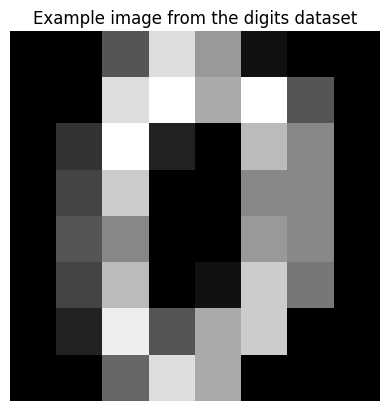

In [3]:
plt.imshow(digits[0].reshape(8,8), cmap='gray')
plt.axis('off')
plt.title('Example image from the digits dataset')
plt.show()

## GAN

Now we can define our GAN. 

The generator is a regular feed-forward neural network whose input is a random noise vector (in our case it is a 8-dimensional vector with each component sampled from $\mathcal{N}(0,1)$). The output is a vector in the shape of the datapoints (in our case a 64-dimensional vector). Since the images have values between 0 and 1, we apply the sigmoid activation function to the last layer of the generator.

The discriminator is another feed-forward neural network where the inputs are images and the output is a single scalar, representing the probability that the input is a *real* image. Since the probability is between 0 and 1, we again apply the sigmoid activation function to the last layer.

In [4]:
latent_dim = 32
generator = nn.Sequential(
    nn.Linear(latent_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Sigmoid()
)

discriminator = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

Let's test them:

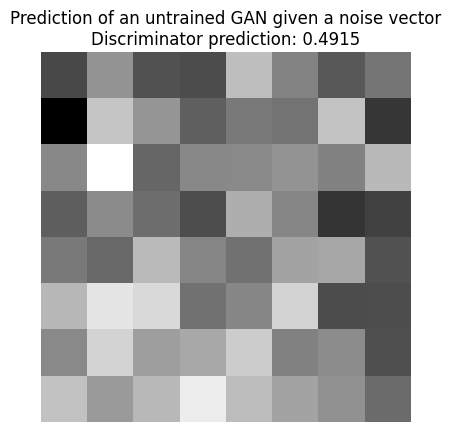

In [5]:
noise = torch.randn(1, latent_dim)
with torch.inference_mode():
    fake_image = generator(noise)
    discriminator_prediction = discriminator(fake_image)
plt.imshow(fake_image.reshape(8,8), cmap='gray')
plt.axis('off')
plt.title(f'Prediction of an untrained GAN given a noise vector\nDiscriminator prediction: {discriminator_prediction.item():.4f}')
plt.show()

As expected, the generation is random noise and the discriminator's prediction is 50/50. Let's train!

## Training

The discriminator is intuitively trained with the binary cross entropy loss as its task is a binary classification problem (real=1, fake=0). The generator is trained via the discriminator, where its aim is for the discriminator to predict 1 given the generated images. Since the two models are trained independently, we need to define an optimizer object for each of them:

In [6]:
loss_fn = nn.BCELoss()
generator_optimizer = torch.optim.Adam(generator.parameters())
discriminator_optimizer = torch.optim.Adam(discriminator.parameters())

We will be using the 2-stage training framework:

- Stage 1: Train the discriminator on a batch of real images and a batch of generated images. Keep the generator fixed.
- Stage 2: Train the generator with the just-updated discriminator's feedback on its recently generated images. Keep the discriminator fixed.


In [7]:
discriminator_filename = 'custom_discriminator.pt'
generator_filename = 'custom_generator.pt'

if os.path.exists(discriminator_filename) and os.path.exists(generator_filename):
    discriminator.load_state_dict(torch.load(discriminator_filename, weights_only=True))
    generator.load_state_dict(torch.load(generator_filename, weights_only=True))
else:
    
    num_epochs = 2001
    
    for epoch in range(num_epochs):
        for i, (X, y) in enumerate(dataloader):
            # Generate labels for real and fake data
            real_targets = torch.ones((X.size()[0],1), device=X.device) 
            fake_targets = torch.zeros((X.size()[0],1), device=X.device)

            # Generate a batch of noise for the generator
            noise = torch.randn(X.size()[0], latent_dim)
    
            # TRAIN DISCRIMINATOR (Stage 1)
            discriminator_optimizer.zero_grad()

            # Train on real images and get loss
            y_pred_real = discriminator(X)
            real_loss = loss_fn(y_pred_real, real_targets)

            # Train on fake images and get loss
            x_generated = generator(noise).detach()  # detach to avoid training G on these labels
            y_pred_fake = discriminator(x_generated)
            fake_loss = loss_fn(y_pred_fake, fake_targets)
            
            # Combine losses -> backprop -> gradient descent
            discriminator_loss = real_loss + fake_loss
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # TRAIN GENERATOR (Stage 2)
            generator_optimizer.zero_grad()

            # Get the predicted labels with the just-updated discriminator
            y_pred_fake = discriminator(generator(noise))

            # Compute generator loss -> backprop -> gradient descent
            generator_loss = loss_fn(y_pred_fake, real_targets)
            generator_loss.backward()
            generator_optimizer.step()
            
        if epoch % 100 == 0:
            print(f"""
                Epoch: {epoch} | \
                D acc real: {(y_pred_real > .5).float().mean().item():.4f} | \
                D acc fake: {(y_pred_fake < .5).float().mean().item():.4f} | \
                D loss: {discriminator_loss.item():.4f} | \
                G loss {generator_loss.item():.4f}
            """)
    torch.save(discriminator.state_dict(), discriminator_filename)
    torch.save(generator.state_dict(), generator_filename)

You may notice that we are training for way more epochs that usual (2000!) and the models still appear to have not converged as their losses are oscillating. That is because they are constantly adapting to each other and is what makes training GANs so hard in practice since good balance must be found. If the discriminator is too good, the generator wouldn't know how to improve. Analogically, if the discriminator is fooled every time, the generator would have no opportunity to get better either.

## Evaluation

We can use our trained generator to create new synthetic datapoints:

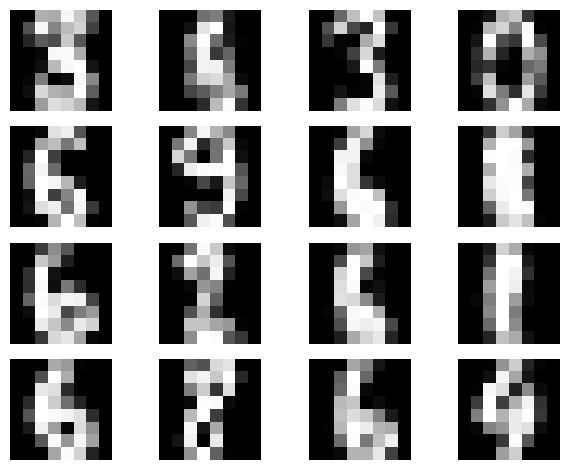

In [8]:
noise = torch.randn(16, latent_dim)
with torch.inference_mode():
    fake_images = generator(noise).reshape(-1, 8, 8)
fig, ax = plt.subplots(4, 4)
for image, a in zip(fake_images, ax.flatten()):
    a.imshow(image, cmap='gray')
    a.axis('off')
plt.tight_layout()
plt.show()

If you really squint your eyes you can see some digit-like patterns!

## Your Task

Although GANs are unsupervised models, they can benefit from the available labels! Implement the so-called Conditional GANs (CGANs), where both the generator and the discriminator receive a label together with their current input. That way we can manually *prompt* the generator to produce images of the digit 4 instead of just generating images of random digits. Normally, the labels are embedded in lower-dimensional space using a separate neural network. In our case we have only 10 labels so we can directly pass them as is (of course, after we have one-hot encoded them).

Naturally, the generator does not receive images as inputs (only random noise), so during training we can just pass random labels to it. Make sure that you pass the same label to the discriminator as well!

In [9]:
# Your code here
latent_dim = 32
num_classes = 10
gen_input_dim = latent_dim + num_classes
disc_input_dim = 64 + num_classes

generator_conditional = nn.Sequential(
    nn.Linear(gen_input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Sigmoid()
)

discriminator_conditional = nn.Sequential(
    nn.Linear(disc_input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
generator_conditional_optimizer = torch.optim.Adam(generator_conditional.parameters())
discriminator_conditional_optimizer = torch.optim.Adam(discriminator_conditional.parameters())

discriminator_filename = 'custom_discriminator_conditional.pt'
generator_filename = 'custom_generator_conditional.pt'

if os.path.exists(discriminator_filename) and os.path.exists(generator_filename):
    discriminator_conditional.load_state_dict(torch.load(discriminator_filename, weights_only=True))
    generator_conditional.load_state_dict(torch.load(generator_filename, weights_only=True))
else:
    num_epochs = 2001
    for epoch in range(num_epochs):
        for i, (X, y) in enumerate(dataloader):
            batch_size = X.size()[0]

            # Generate labels for real and fake data
            real_targets = torch.ones((batch_size,1), device=X.device) 
            fake_targets = torch.zeros((batch_size,1), device=X.device)

            one_hot = F.one_hot(y, num_classes=num_classes).float()
            gen_input = torch.cat((torch.randn(batch_size, latent_dim), one_hot), dim=1)
    
            # TRAIN DISCRIMINATOR (Stage 1)
            discriminator_conditional_optimizer.zero_grad()

            # Train on real images and get loss
            disc_in_real = torch.cat((X, one_hot), dim=1)
            y_pred_real = discriminator_conditional(disc_in_real)
            real_loss = loss_fn(y_pred_real, real_targets)
            
            # Train on fake images and get loss
            x_generated = generator_conditional(gen_input).detach()  # detach to avoid training G on these labels
            disc_in_fake = torch.cat((x_generated, one_hot), dim=1)
            y_pred_fake = discriminator_conditional(disc_in_fake)
            fake_loss = loss_fn(y_pred_fake, fake_targets)
    
            # Combine losses -> backprop -> gradient descent
            discriminator_loss = real_loss + fake_loss
            discriminator_loss.backward()
            discriminator_conditional_optimizer.step()
            
            # TRAIN GENERATOR (Stage 2)
            generator_conditional_optimizer.zero_grad()

            # Get the predicted labels with the just-updated discriminator
            disc_in_fake = torch.cat((generator_conditional(gen_input), one_hot), dim=1)
            y_pred_fake = discriminator_conditional(disc_in_fake)

            # Compute generator loss -> backprop -> gradient descent
            generator_loss = loss_fn(y_pred_fake, real_targets)
            generator_loss.backward()
            generator_conditional_optimizer.step()
            
        if epoch % 100 == 0:
            print(f"""
                Epoch: {epoch} | \
                D acc real: {(y_pred_real > .5).float().mean().item():.4f} | \
                D acc fake: {(y_pred_fake < .5).float().mean().item():.4f} | \
                D loss: {discriminator_loss.item():.4f} | \
                G loss {generator_loss.item():.4f}
            """)
    torch.save(discriminator_conditional.state_dict(), discriminator_filename)
    torch.save(generator_conditional.state_dict(), generator_filename)



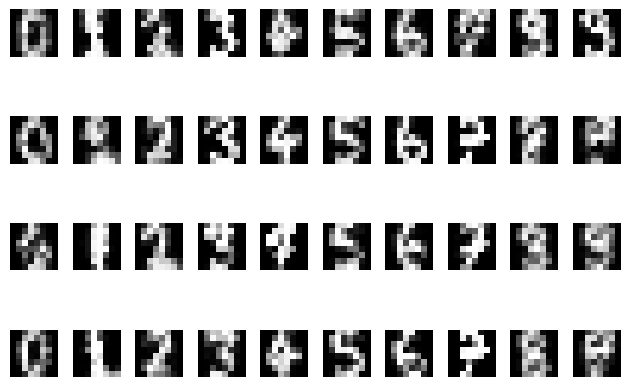

In [11]:
n_images_per_class = 4
noise = torch.randn(n_images_per_class * num_classes, latent_dim)
one_hot = F.one_hot(torch.arange(num_classes).repeat_interleave(n_images_per_class), num_classes=num_classes).float()
gen_input = torch.cat((noise, one_hot), dim=1)
with torch.inference_mode():
    fake_images = generator_conditional(gen_input).reshape(-1, 8, 8)

fig, ax = plt.subplots(n_images_per_class, num_classes)
for image, a in zip(fake_images, ax.swapaxes(0, 1).flatten()):
    a.imshow(image, cmap='gray')
    a.axis('off')
plt.tight_layout()
plt.show()